In [27]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


#### 图片读取并展示

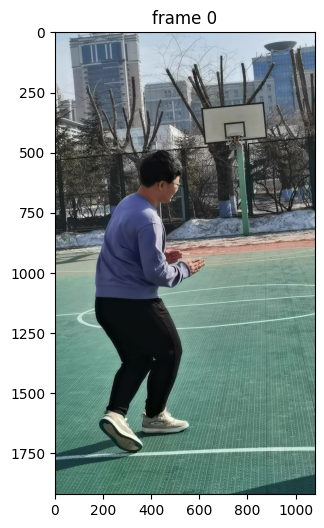

In [2]:
video_dir = "../../data/video_to_frame"
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### 图片修饰函数

In [3]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    """
    在指定的轴上绘制带有颜色的掩码图像
    :param mask: 掩码图像，形状为(H, W)或(H, W, 1)
    :param ax: 绘图轴
    :param obj_id: 对象的ID，用于选择颜色
    :param random_color: 是否随机选择颜色
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    """
    在指定的轴上绘制正点和负点
    :param coords: 坐标，形状为(N, 2)
    :param labels: 标签，形状为(N,)
    :param ax: 绘图轴
    :param marker_size: 正点和负点的大小
    """
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    """
    在指定的轴上绘制矩形框
    :param box: 矩形框，形状为(4,)，表示左上角和右下角的坐标
    :param ax: 绘图轴
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### 模型权重 配置

In [4]:
# 预训练模型的权重文件
sam2_checkpoint_list = [
    "./segment-anything-2/checkpoints/sam2_hiera_tiny.pt",
    "./segment-anything-2/checkpoints/sam2_hiera_small.pt",
    "./segment-anything-2/checkpoints/sam2_hiera_base_plus.pt",
    "./segment-anything-2/checkpoints/sam2_hiera_large.pt",
]
# 配置文件
# tiny, small, base_plus, large
model_cfg_list = [
    "sam2_hiera_t.yaml",
    "sam2_hiera_s.yaml",
    "sam2_hiera_b+.yaml",
    "sam2_hiera_l.yaml",
]

#### 最高配置

In [5]:
sam2_checkpoint = sam2_checkpoint_list[3]
model_cfg = model_cfg_list[3]
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

##### 初始化 重置状态

In [9]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 255/255 [00:11<00:00, 21.78it/s]


##### 交互式的分割

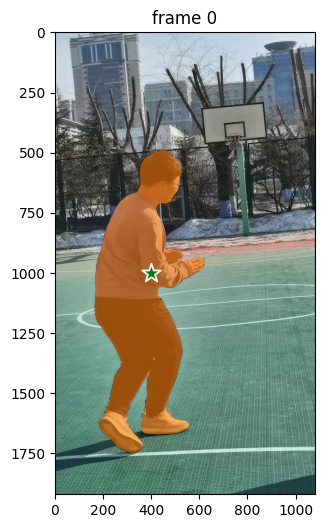

In [26]:
ann_frame_idx = 0  # 视频帧索引 第一帧
ann_obj_id = 1  # 目标对象ID 唯一的标识符 1

# 添加正点击
points = np.array([[400, 1000]], dtype=np.float32)
labels = np.array([1], np.int32)
# _,预测出的对象标识符列表,预测出的掩码预测值列表
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id, 
    points=points,
    labels=labels,
)

# 显示结果
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

##### 学习对象分割,输出结果

propagate in video:   0%|          | 0/255 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 255/255 [02:56<00:00,  1.44it/s]


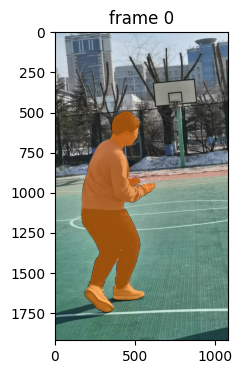

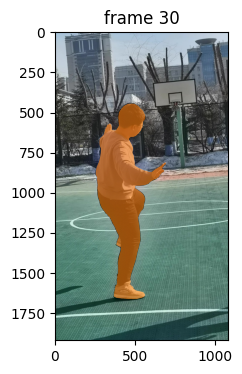

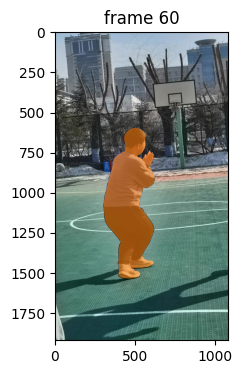

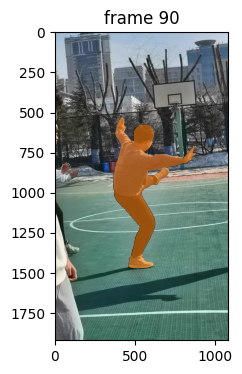

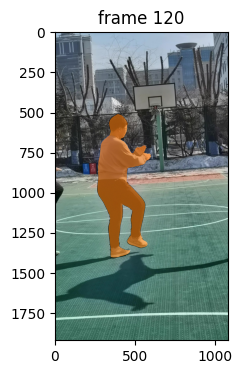

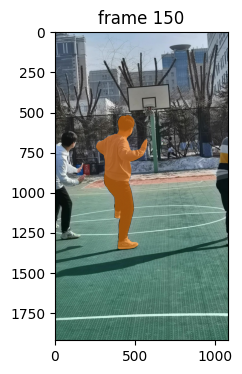

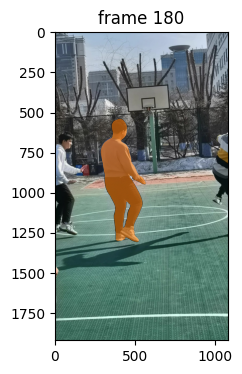

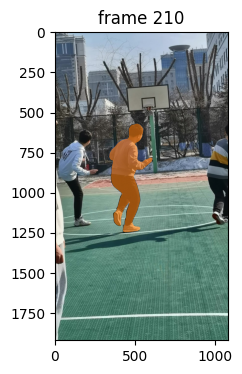

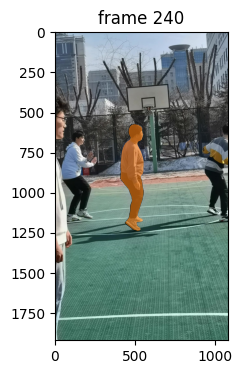

In [8]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

##### 全要素分割

In [10]:
predictor.reset_state(inference_state)

In [18]:
# x = np.arange(0, 1001, 100)
# print(x)
# y = np.arange(0, 1801, 100)
# print(y)
# X, Y = np.meshgrid(x, y)
# print(np.meshgrid(x, y))
# # print(X)
# # print(Y)
# points = np.column_stack((X.ravel(), Y.ravel()))
# points = points.astype(np.float32)
# print(points)

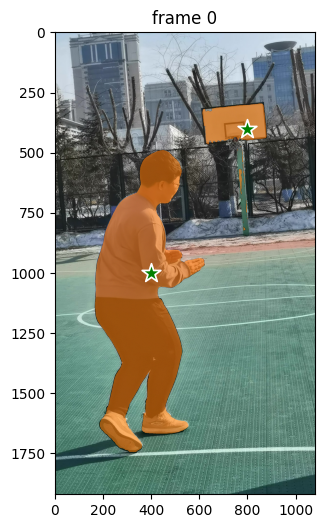

In [17]:
ann_frame_idx = 0  # 视频帧索引 第一帧
ann_obj_id = 1  # 目标对象ID 唯一的标识符 1

# 添加正点击
# points = np.array([[400, 1000]], dtype=np.float32)
# labels = np.array([1], np.int32)

# step = 20
# length = 1001
# height = 1801
# x = np.arange(0, length, step)
# y = np.arange(0, height, step)
# X, Y = np.meshgrid(x, y)
# points = np.column_stack((X.ravel(), Y.ravel()))
# points = points.astype(np.float32)
# labels = np.array([1]*int(((length-1)/step+1)*((height-1)/step+1)), np.int32)

points = np.array([[400, 1000], [800, 400]], dtype=np.float32)
labels = np.array([1, 1], np.int32)

# _,预测出的对象标识符列表,预测出的掩码预测值列表
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id, 
    points=points,
    labels=labels,
)

# 显示结果
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

ImportError: cannot import name 'SamAutomaticMaskGenerator' from 'segment_anything_2' (unknown location)

#### 最低配置

In [9]:
sam2_checkpoint = sam2_checkpoint_list[0]
model_cfg = model_cfg_list[0]
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

##### 初始化 重置状态

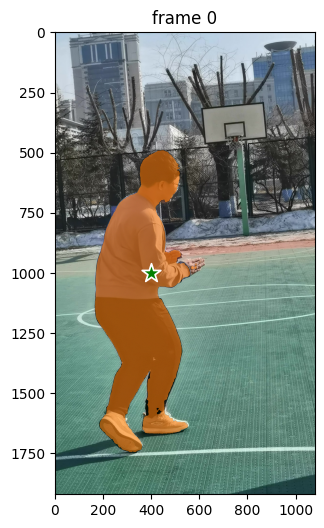

In [10]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[400, 1000]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

发现不对劲

##### 交互式的分割

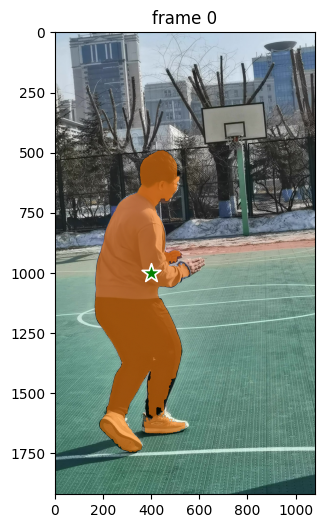

In [12]:
ann_frame_idx = 0  # 视频帧索引 第一帧
ann_obj_id = 1  # 目标对象ID 唯一的标识符 1

# 添加正点击
points = np.array([[400, 1000]], dtype=np.float32)
labels = np.array([1], np.int32)
# _,预测出的对象标识符列表,预测出的掩码预测值列表
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id, 
    points=points,
    labels=labels,
)

# 显示结果
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

##### 学习对象分割,输出结果
属于什么都没分出来

propagate in video: 100%|██████████| 255/255 [01:25<00:00,  2.99it/s]


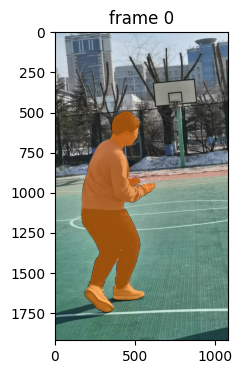

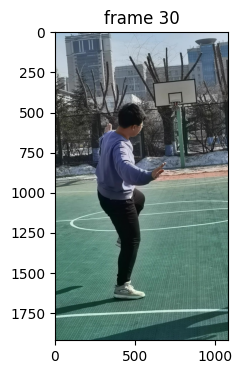

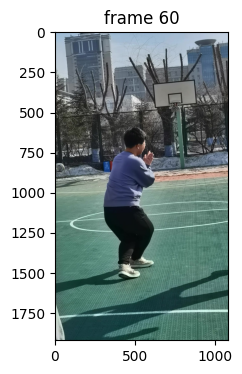

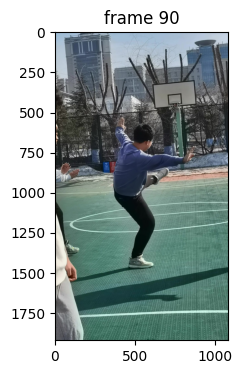

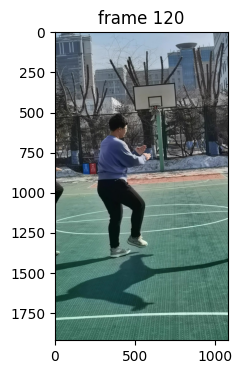

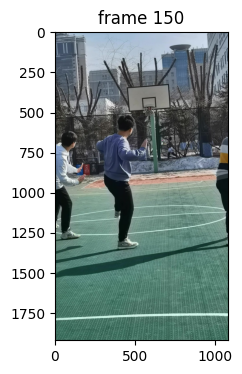

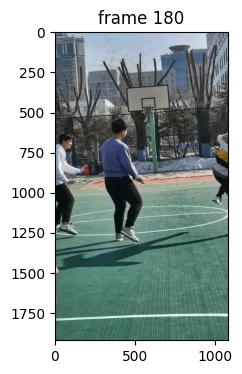

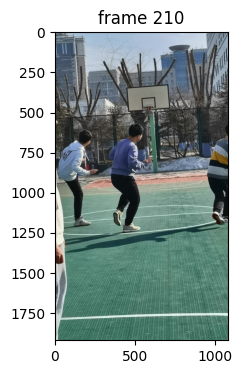

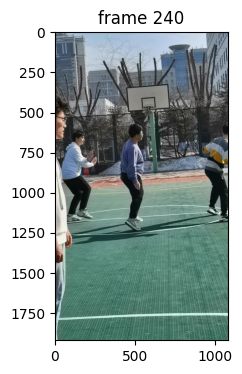

In [13]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)